# Introduction

Ici je vais écrire la version finale de la méthode EM pour le *cas 3 : Contrainte de pureté*


1. [Loading of datasets](#Load-datasets)
2. [Transformation of datasets](#Transform-datasets)
3. [Helper functions](#Helper-functions)
4. [Manual EMANN](#Manual-EMANN)
    1. [EM Starts Here !](#EM-Starts-Here-!)
5. [Test the result](#Test-the-result)


[**[Back to top]**](#Introduction)

In [1]:
from __future__ import division, print_function
import sys
if '..' not in sys.path:
    sys.path.append('..')

import theano
import theano.tensor as T
import lasagne

import time
import visual

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix, pairwise_distances

from nn.helper import CNN, NN
from nn import block as nnb
from nn import compilers as nnc


Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN 3007)


In [2]:
%matplotlib inline

# Load datasets

- the datasets are loaded/built.
- The batchsize is defined
- half of the data name (the source part) is defined

[**[Back to top]**](#Introduction)

## Datasets Imports 

In [3]:
from datasets.toys import make_clouds, make_circles, make_X, make_moons
from datasets.utils import make_dataset, make_domain_dataset


# Transform datasets

- the transformed datasets are built.
- last part of the data name (the target part) is defined

[**[Back to top]**](#Introduction)

## Transformation Imports

In [4]:
from datasets.utils import make_domain_dataset, make_corrector_dataset
import datasets.transform as transform

# Helper functions

[**[Back to top]**](#Introduction)

In [5]:
# Import loggers
from logs import new_logger, empty_logger
logger = new_logger()

In [6]:
def mass(labels):
    """
    Params
    ------
        labels: labels for each data point giving the partition it belongs to.
    Return
    ------
        w: (numpy.array [n_clusters]) the mass of each clusters/partitions. 
    """
    w = np.unique(labels, return_counts=True)[1]
    w = w/np.sum(w)
    return w
    

In [7]:
def align(P, y_src, y_tgt):
    """
    Return indexes of the chosen target data.
    then
    >>> X_S, y_S = X_src, y_src
    >>> X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]
    coresponding transport lines and columns = k_means_src.labels_, k_means_tgt.labels_[idx_tgt]

    Params
    ------
        P: the transport/probability matrix
        y_src: the source's data labels
        y_tgt: the target's data labels

    Return
    ------
        align_idx, cluster_T
    """
    labels_src = np.unique(y_src)
    labels_tgt = np.unique(y_tgt)
    src_slices = [np.where(y_src == l_src)[0] for l_src in labels_src]
    tgt_slices = [np.where(y_tgt == l_tgt)[0] for l_tgt in labels_tgt]
    # src member of cluster i go to some tgt cluster j 
    # with the probability in the i-th row of transport matrix
    cluster_choice = [np.random.choice(len(tgt_slices), size=src_idx.shape, p=P[i]/np.sum(P[i])) 
           for i, src_idx in enumerate(src_slices)]
    # Stack it into array. And use the former indexes to match X_src with X_tgt[res]
    cluster_choice_array = np.hstack(cluster_choice)[np.hstack(src_slices)]
    align_idx = np.array([np.random.choice(tgt_slices[i]) for i in cluster_choice_array])
    return align_idx


In [8]:
# align_idx = align(P, y_src, y_tgt)
# X_S, y_S = X_src, y_src
# X_T, y_T = X_tgt[align_idx], y_tgt[align_idx]
# p_src, p_tgt = proba_src_P(P, y_src, y_tgt)


def proba_src_P(P, y_src, y_tgt):
    """
    return the probability of the given 
    """
    # Build the probabilities to be predict
    # For the source data in the source distribution/partition
    n_label = len(np.unique(y_src))
    n_sample = y_src.shape[0]
    proba_src = np.zeros((n_sample, n_label))
    proba_src[np.arange(n_sample), y_src] = 1.
    
    # For the target data in the source distribution/partition
    proba_tgt = P[:, y_tgt].T
    proba_tgt = proba_tgt / np.sum(proba_tgt, 1)[:, np.newaxis]
    
    return proba_src, proba_tgt

def proba_tgt_P(P, y_src, y_tgt):
    """
    return the probability of the given 
    """
    # Build the probabilities to be predict
    # For the target data in the target distribution/partition
    n_label = len(np.unique(y_tgt))
    n_sample = y_tgt.shape[0]
    proba_tgt = np.zeros((n_sample, n_label))
    proba_tgt[np.arange(n_sample), y_tgt] = 1.
    
    # For the source data in the target distribution/partition
    proba_src = P[y_src]
    proba_src = proba_src / np.sum(proba_src, 1)[:, np.newaxis]
    
    return proba_src, proba_tgt

In [9]:
def renorm(M, w_S=None, w_T=None, max_iter=200, epsilon=1e-6, last='line'):
    """
    """
    # init data
    # ---------
    if w_S is None:
        w_S = np.ones(np.shape(M)[0])
    if w_T is None:
        w_T = np.ones(np.shape(M)[1])
    Nini = len(w_S)
    Nfin = len(w_T)
    
    # we assume that no distances are null except those of the diagonal of distances
    u = np.ones(Nini)/Nini
    v = np.ones(Nfin)/Nfin
    uprev = np.zeros(Nini)
    cpt = 0
    err = 1
    # Main loop
    # ---------
    while (err > epsilon and cpt < max_iter):
        cpt = cpt +1
        # First we do a sanity check
        if np.logical_or(np.any(np.dot(M.T,u)==0),np.isnan(np.sum(u))):
            # we have reached the machine precision
            # come back to previous solution and quit loop
            print('Infinity')
            if cpt!=0:
                u = uprev
            break
        uprev = u  # Save the previous results in case of divide by 0
        # now the real algo part : update vectors u and v
        v = w_T/np.dot(M.T,u)
        u = w_S/np.dot(M,v)
        # Computing the new error value
        if cpt%10==0:
            # we can speed up the process by checking for the error only all the n-th iterations
            final = u[:, np.newaxis]*M*v[:, np.newaxis].T
            err = np.linalg.norm((np.sum(final, axis=0)-w_T))**2
    # End of Main loop
    # Return the transpotation matrix
    if last=='column':
        v = w_T/np.dot(M.T,u)
    return u[:, np.newaxis]*M*v[:, np.newaxis].T


Softmax_alpha computes :

$$res_{ij} = \frac{e^{\alpha x_{ij}}}{\sum_j e^{\alpha x_{ij}}}$$

In [10]:
def softmax_alpha(x, alpha=1.0):
    """
    Compute softmax values for each sets of scores in x.
    
    $res_{ij} = \frac{e^{\alpha x_{ij}}}{\sum_j e^{\alpha x_{ij}}}$
    """
    e_x = np.exp(alpha*(x - np.max(x)))
    return e_x / e_x.sum(1)[:, np.newaxis]

# Manual EMANN

[**[Back to top]**](#Introduction)

In [11]:
EM_ITER = 0

## Generate data

Première étape : générer les données

In [12]:
n_classes_1 = 4
n_classes_2 = 4
n_samples = 1000
X_src, y_src = make_clouds(n_samples=n_samples, n_classes=n_classes_1)

X_tgt, y_tgt = make_clouds(n_samples=n_samples, n_classes=n_classes_1)
# X_tgt, y_tgt = make_circles(n_samples=n_samples,  n_classes=n_classes_2)

data_name='Clouds -> Same'

## Clusters

Choisir/construire les partitions $C_{1i}$ et $C_{2j}$. 

Avoir des labels pour chaque points, placés dans $l_{src}$ et $l_{tgt}$. On garde $y_{src}$ et $y_{tgt}$ pour les véritables labels de classe.

In [13]:
from sklearn.cluster import KMeans

k_src = 10
k_tgt = 12
# We do not need to have the same number of cluster in the source and target data.
k_means_src = KMeans(n_clusters=k_src).fit(X_src)
k_means_tgt = KMeans(n_clusters=k_tgt).fit(X_tgt)
# labels
l_src, l_tgt = k_means_src.labels_, k_means_tgt.labels_
# l_src, l_tgt = np.asarray(y_src, dtype=int), np.asarray(y_tgt, dtype=int),

# Mass
w_src = mass(l_src)
w_tgt = mass(l_tgt)

# Params
n_class_tgt = len(np.unique(l_tgt))
n_class_src = len(np.unique(l_src))

## Initialisation de la matrice de proba du plongement.

On met dans $P_{ij}$ la probabilité de plongement d'élément de la partition $C_{1i}$ dans $C_{2j}$

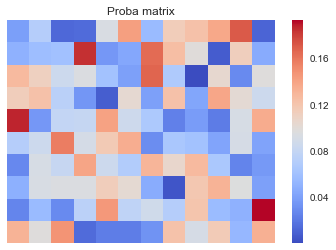

In [14]:
P = np.random.uniform(0,1, size=(n_class_src, n_class_tgt))
P = renorm(P)
visual.mat(P)
plt.title("Proba matrix")
plt.show()

## Training dataset

Build the training datasets.

The data from the source and the target distribution ordered so $x_s$ should correspond to $x_t$.

The target is the probability that $x$ belong to the label $y$ in the source space

In [19]:
# Get the alignment indexes according to the given probability matrix
align_idx = align(P, l_src, l_tgt)
# Align the data
X_S, y_S = X_src, l_src
X_T, y_T = X_tgt[align_idx], l_tgt[align_idx]
# Get the probability to be predicted for each couple of data point.
# p_src, p_tgt = proba_src_P(P, l_src, l_tgt)
# n_class = n_class_src
p_src, p_tgt = proba_tgt_P(P, l_src, l_tgt)
n_class = n_class_tgt

# Shuffle it all to prevent the index to be correclated to the labels
indices = np.arange(X_S.shape[0])
np.random.shuffle(indices)
X_S, X_T, p_src, p_tgt = X_S[indices], X_T[indices], p_src[indices], p_tgt[indices]
l_src, l_tgt = l_src[indices], l_tgt[indices]
# Build split dataset (train, valid, test)
src_data = make_dataset(X_S, p_src, batchsize=100)
tgt_data = make_dataset(X_T, p_tgt, batchsize=100)
adversarial_data = make_domain_dataset([src_data, tgt_data])

## Neural Network Architecture

2 entries : 
- one for the source data. The source data goes throught 2 NN parts $\varphi$ (projection to target space) and $\rho$ (classifier)
- one for the target data. The target data goes throught 1 NN parts $\rho$ (classifier)

$\rho(\varphi (x_s)) = P(x_s\in C_{1i})$

$\rho(x_t) = P(x_t\in C_{1i} || x_t\in C_{2j})$

In [24]:
# Get general information :
# =========================
batchsize = src_data.batchsize
_shape = np.shape(src_data.X_train)
n_dim = len(_shape)
n_features = np.prod(_shape[1:])

shape = (batchsize,) + _shape[1:]
target_var = T.ivector('targets')

# Logs
logger.info('Building the input and output variables for : {}'.format(data_name))
logger.info('Input data expected shape : {}'.format(shape))

# WARNING :: Une seule couche de proba. On prédit les lignes pas les colonnes !
# Build the layers :
# ==================
# Inputs layers
# -------------
input_layer_src = lasagne.layers.InputLayer(shape=shape)
input_layer_tgt = lasagne.layers.InputLayer(shape=shape)

# Representaion layers for the source data
# ----------------------------------------
dense_1 = lasagne.layers.DenseLayer(input_layer_src, 3, nonlinearity=lasagne.nonlinearities.sigmoid)
dense_2 = lasagne.layers.DenseLayer(dense_1, shape[1], nonlinearity=None)
repr_layer = dense_2

# "Classification" layers for the source data
# -------------------------------------------
# WARNING :: Une seule couche de proba. On prédit les lignes pas les colonnes !
# last = lasagne.layers.NonlinearityLayer(dense_2, nonlinearity=lasagne.nonlinearities.sigmoid)
# dense_3 = lasagne.layers.DenseLayer(last, 2, nonlinearity=lasagne.nonlinearities.sigmoid)
cluster_src = lasagne.layers.DenseLayer(repr_layer, n_class, nonlinearity=lasagne.nonlinearities.softmax)

# "Classification" layers for the target data
# -------------------------------------------
# WARNING :: Une seule couche de proba. On prédit les lignes pas les colonnes !
cluster_tgt = lasagne.layers.DenseLayer(input_layer_tgt, n_class, nonlinearity=lasagne.nonlinearities.softmax,
                                         W=cluster_src.W, b=cluster_src.b)

[11:47:27] INFO    : Building the input and output variables for : Clouds -> Same
[11:47:27] INFO    : Input data expected shape : (100, 2)


## Compile the NN

Compile the functions:
- training, validation, proba output for the source path
- training, validation, proba output for the target path
- raw output for the representation
- training, validation, proba output for the adverssarial path


In [25]:
# Instanciate the NN :
# ====================
nn = CNN(name='EMANN test')
nn.add_output('proba_src', cluster_src)
nn.add_output('proba_tgt', cluster_tgt)
nn.add_output('repr', repr_layer)
# Ok for the adversarial the code is not intuitive. [Further work]
nn.add_output('adversarial', [repr_layer, input_layer_tgt])

# Compile :
# =========
nn.compile('proba_src', nnc.crossentropy_sgd_mom, lr=0.1, mom=0.9)
nn.compile('proba_src', nnc.crossentropy_validation)
nn.compile('proba_src', nnc.output)
nn.compile('proba_tgt', nnc.crossentropy_sgd_mom, lr=0.1, mom=0.9)
nn.compile('proba_tgt', nnc.crossentropy_validation)
nn.compile('proba_tgt', nnc.output)
nn.compile('repr', nnc.output)
nn.compile('adversarial', nnc.adversarial, hp_lambda=0, lr=1, mom=0.9)

logger.info("Compilation Done")

[11:47:31] INFO    : Compilation Done


## Train the NN

Now is the training session.

It altarnatively (mini-batch after mini-batch) train (forwward-backward propagation) each part of the neural network.

- Source data $\to$ Predict the label of the source data in the source space
- Target data $\to$ Predict the probability of being in the partition of the target data in the source space
- Adversarial $\to$ Predict from wich distribution the data comes from (Source or Target)



In [26]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([src_data, tgt_data, adversarial_data], ['proba_src', 'proba_tgt', 'adversarial'], num_epochs=50);

/home/victor/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


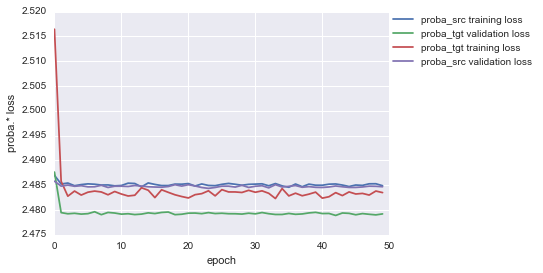

In [27]:
# ================
# Learning curve
# ================
# Usefull regex : 'proba.* loss', 'loss', 'acc'
fig, ax = visual.learning_curve(nn.global_stats, regex='proba.* loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

## Check some results

Check the output of the NN:

The predicted probability of being in a partition **vs** the true value.

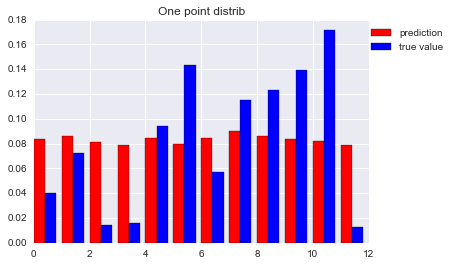

In [29]:
y_pred = nn.parts['proba_src'].output(src_data.X_test)[0]
i = np.random.randint(0, src_data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(n_class), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(n_class)+width, src_data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

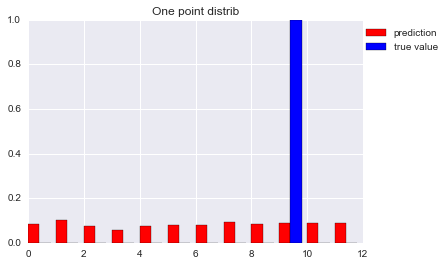

In [30]:
y_pred = nn.parts['proba_tgt'].output(tgt_data.X_test)[0]
i = np.random.randint(0, tgt_data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(n_class), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(n_class)+width, tgt_data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

## **EM Starts Here !**

[**[Back to top]**](#Introduction)

**Rebuild P**

In [ ]:
# Get some outputs for the lines of P
# -----------------------------------
n_samples = X_T.shape[0]
n_train = int(0.6*n_samples)
n_val = int(0.15*n_samples)+n_train

# for each label
for l in np.unique(l_tgt):
    # get some points
    a = tgt_data.X_train[np.where(l_tgt[:n_train])]
    x = a[np.random.choice(a.shape[0], size=10, replace=False)]
    # get the output of the NN
    p = nn.parts['proba_tgt'].output(x)
    # Agregate lines
    P[:, l] = np.median(p, axis=1)
# Update P

# P = softmax_alpha(P, alpha=15)

fig, ax = visual.mat(P)
plt.title("Proba matrix")
plt.show()

**Dual Proba dataset**

In [ ]:
# Get the alignment indexes according to the given probability matrix
align_idx = align(P, l_src, l_tgt)
# Align the data
X_S, y_S = X_src, l_src
X_T, y_T = X_tgt[align_idx], l_tgt[align_idx]
# Get the probability to be predicted for each couple of data point.
# p_src, p_tgt = proba_src_P(P, l_src, l_tgt)
# n_class = n_class_src
p_src, p_tgt = proba_tgt_P(P, l_src, l_tgt)
n_class = n_class_tgt

# Shuffle it all to prevent the index to be correclated to the labels
indices = np.arange(X_S.shape[0])
np.random.shuffle(indices)
X_S, X_T, p_src, p_tgt = X_S[indices], X_T[indices], p_src[indices], p_tgt[indices]
# Build split dataset (train, valid, test)
src_data = make_dataset(X_S, p_src, batchsize=100)
tgt_data = make_dataset(X_T, p_tgt, batchsize=100)

**Neural network** (re-initialization)

**Train the NN**

In [ ]:
# Train the nn :
# ==============
# nn.train(data, num_epochs=100);
nn.train([src_data, tgt_data, adversarial_data], ['proba_src', 'proba_tgt', 'adversarial'], num_epochs=50);


In [ ]:
EM_ITER += 1
print('Iteration n*', EM_ITER)

In [ ]:
# ================
# Learning curve
# ================
# Usefull regex : 'proba.* loss', 'loss', 'acc'
fig, ax = visual.learning_curve(nn.global_stats, regex='proba.* loss')
#     SAVE
# fig.tight_layout()
# fig.savefig(fig_title+'-Learning_curve.png',bbox_inches='tight')
fig.show()

**Check some results**

In [ ]:
y_pred = nn.parts['proba_src'].output(src_data.X_test)[0]
i = np.random.randint(0, src_data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(n_class), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(n_class)+width, src_data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

In [ ]:
y_pred = nn.parts['proba_tgt'].output(tgt_data.X_test)[0]
i = np.random.randint(0, tgt_data.X_test.shape[0])
# print('\n'.join('{:1.5f}--{:1.5f}'.format(pred, truth) for pred, truth in zip(y_pred[i], data.y_test[i])))
width=0.4
plt.bar(np.arange(n_class), y_pred[i], width, color='r', label='prediction')
plt.bar(np.arange(n_class)+width, tgt_data.y_test[i], width, color='b', label='true value')
plt.title("One point distrib")
plt.legend(bbox_to_anchor=(1.25,1.))
# plt.yscale('log')
plt.show()

[**[EM LOOP]**](#EM-Starts-Here-!)

# Test the result

[**[Back to top]**](#Introduction)

In [ ]:
X = nn.parts['repr'].output(X_src)[0]
fig, ax = visual.corrected_2D(X, y_src);
# visual.target_2D(X_tgt, y_tgt, ax=ax);
visual.add_legend(ax)


# Remaining work

- Agregate the output of the NN to update P
- Have pertinent graphics and results monitoring

- **Build 2 similar Notebooks for case 1 and case 2**